In [ ]:
#default_exp core.cult

In [ ]:
#export
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
import os
import numpy as np
import copy
from tqdm import tqdm

from cult.core.models import FCEncoder, FCDecoder, CNNEncoder, CNNDecoder, EnvironmentInference
from cult.core.utils import rec_likelihood, disable_gradient, kl_div_stdnorm, euclidean, show_batch, save_model, load_model
from cult.config import DATA_PATH, LOG_PATH, PARAM_PATH

In [ ]:
#hide
from cult.core.datasets.moving_mnist import CommonMNIST, CommonFashionMNIST, MovingMNIST, MovingFashionMNIST, FixedMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import datetime as dt

In [ ]:
batch_size = 64

In [ ]:
#hide
mnist_data = CommonMNIST(DATA_PATH, transform=ToTensor(), download=True)
mnist_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
mnist_batch, _ = iter(mnist_loader).next()
small_fashion = CommonFashionMNIST(DATA_PATH, transform=ToTensor())
sf_loader = DataLoader(small_fashion, batch_size=batch_size, shuffle=True)
sf_batch, _ = iter(sf_loader).next()
fashion_data = MovingFashionMNIST(DATA_PATH, transform=ToTensor(), download=True)
fashion_loader = DataLoader(fashion_data, batch_size, shuffle=True)
fashion_batch, _, _ = iter(fashion_loader).next()
mm_data = MovingMNIST(DATA_PATH, transform=ToTensor(), download=True)
mm_loader = DataLoader(mm_data, batch_size, shuffle=True)
mm_batch, _, _ = iter(mm_loader).next()

mnist_test = CommonMNIST(DATA_PATH, transform=ToTensor(), train=False, download=True)
mnist_test_loader =  DataLoader(mnist_test, batch_size=batch_size, shuffle=True)
mnist_test_batch, _ = iter(mnist_test_loader).next()

fashion_test = CommonFashionMNIST(DATA_PATH, transform=ToTensor(), train=False, download=True)
fashion_test_loader = DataLoader(fashion_test, batch_size=batch_size, shuffle=True)
fashion_test_batch, _ = iter(fashion_test_loader).next()


# Continually Learning Variational Autoencoder
> Performs unsupervised continual representation learning with generative replay and environment likelihood detection

Notes: assumes sequential tasks - "local stationarity" i.e. will stay on distribution long enough to learn it

In [ ]:
#export
class CULT(nn.Module):
    def __init__(self, 
        encoder_type: type,
        decoder_type: type,
        final_size: int, 
        latents: int,
        max_envs: int,
        atyp_min: float,
        atyp_max: float,
        env_optim: type,
        env_lr: float,
        env_epochs: int,
        replay_batch_size: int,
        device: str,
        steps_per_reset: int=None,
    ):
        super().__init__()
        self.latents = latents
        self.max_envs = max_envs
        self.final_size = final_size
        self.atyp_min = atyp_min
        self.atyp_max = atyp_max
        self.device = device
        self.encoder = encoder_type(self.latents, device=self.device)
        self.decoder = decoder_type(self.latents, self.max_envs, device=self.device)
        self.old_encoder = encoder_type(self.latents, device=self.device)
        self.old_decoder = decoder_type(self.latents, self.max_envs, device=self.device)
        self.copy_and_freeze()
        self.encoder.to(self.device), self.decoder.to(self.device), self.old_encoder.to(self.device), self.old_decoder.to(self.device)
        self.replay_batch_size = replay_batch_size
        self.env_lr = env_lr
        self.env_optim_type = env_optim
        self.reset_env_net()
        self.env_loss = nn.CrossEntropyLoss()
        self.env_epochs = env_epochs
        self.steps_per_reset = steps_per_reset
       
        self.m = -1
        self.steps = 0
        self.learning = False

    def forward(self, x):
        batch_size = x.shape[0]
        self.steps += 1

        x_halu, s_halu = self.sample_old()
        
        mu, logvar, final = self.encoder(x)

        if not self.training:
            z = mu 
            s = torch.argmax(self.env_net(final)[:, 0:self.m+1], dim=1)
            rec_x = self.decoder(z, self.int_to_vec(s, batch_size))
            atyp = self.get_atyp(z)
            mu_halu_old, logvar_halu_old, final_halu_old = self.old_encoder(x_halu)
            mu_halu, logvar_halu, final_halu = self.encoder(x_halu)
            rec_x_halo = self.decoder(mu_halu, s_halu)
            return rec_x, mu, logvar, x_halu, rec_x_halo, mu_halu_old, mu_halu, s_halu, atyp
        
        s = self.m if self.m != -1 else 0
        z = self.reparam(mu, logvar)
        rec_x = self.decoder(z, self.int_to_vec(s, batch_size))

        atyp = self.get_atyp(z)

        if self.m == -1:
            if atyp > self.atyp_max:
                self.m = 0
                self.learning = True
        
        elif self.learning:
            if atyp < self.atyp_min:
                self.learning = False
        
        elif atyp > self.atyp_max:
            self.learning = True
            self.m += 1
            if self.m > self.max_envs:
                print("Warning: too many environments")
            if self.steps_per_reset is None:
                self.copy_and_freeze()
                self.reset_env_net()
        
        if self.steps_per_reset is not None and self.steps % self.steps_per_reset == 0:
            self.copy_and_freeze()
            self.reset_env_net()

        
        with torch.no_grad():
            mu_halu_old, logvar_halu_old, final_halu_old = self.old_encoder(x_halu)
            z_halu_old = self.reparam(mu_halu_old, logvar_halu_old)
        
        mu_halu, logvar_halu, final_halu = self.encoder(x_halu)
        z_halu = self.reparam(mu_halu, logvar_halu)
        rec_x_halo = self.decoder(z_halu, s_halu)

        avg_env_loss, env_acc = self.train_env_network(final, s, final_halu_old, s_halu) if self.training else 0

        return rec_x, mu, logvar, x_halu, rec_x_halo, z_halu_old, z_halu, s_halu, atyp, avg_env_loss, env_acc

    def get_likely_env(self, final):
        env_logits = self.env_net(final)
        avg_env_logits = torch.mean(env_logits, dim=0)
        valid_logits = avg_env_logits[0:self.m+1]
        return torch.argmax(valid_logits), env_logits
    
    def get_atyp(self, z):
        with torch.no_grad():
            std, mean = torch.std_mean(z, dim=0)
            std = std[:,None]
            mean = mean[:, None]
            logvar = torch.log(std.pow(2))
            atyps = kl_div_stdnorm(mean, logvar)
        return torch.sum(atyps)
    
    def reparam(self, mu, logvar):
        eps = torch.randn(logvar.shape).to(self.device)
        std = (0.5 * logvar).exp()
        return mu + std * eps
    
    def int_to_vec(self, i, size):
        return torch.ones([size], dtype=torch.int64).to(self.device) * i
    
    def copy_model(self, old_model, cur_model):
        old_model.load_state_dict(cur_model.state_dict())
    
    def freeze_model(self, model):
        disable_gradient(model)
    
    def copy_and_freeze(self):
        self.copy_model(self.old_encoder, self.encoder)
        self.freeze_model(self.old_encoder)
        self.copy_model(self.old_decoder, self.decoder)
        self.freeze_model(self.old_decoder)
    
    def train_env_network(self, final, s, final_halu_old, s_halu):
        total_env_loss = 0
        total_acc = 0
        total_logits = 0
        for epoch in range(self.env_epochs):
            self.env_optim.zero_grad()
            env_logits = self.env_net(final)
            final_halu_old = final_halu_old[s != s_halu]
            s_halu = s_halu[s != s_halu]
            cur_loss = self.env_loss(env_logits, self.int_to_vec(s, env_logits.shape[0])) #don't know if dims work here
            if len(s_halu) > 0:
                env_logits_halu = self.env_net(final_halu_old)
                replay_loss = self.env_loss(env_logits_halu, s_halu)
            else: 
                replay_loss = 0
            loss = cur_loss + 2 * replay_loss #TODO: set as hyperparam
            loss.backward(retain_graph=True)
            total_env_loss += loss
            self.env_optim.step()
            env_accc = (torch.argmax(env_logits, dim=1) == s).sum()
            halu_acc = (torch.argmax(env_logits_halu) == s_halu).sum() if len(s_halu) > 0 else 0
            total_acc += env_accc + halu_acc
            total_logits += env_logits.shape[0] + env_logits_halu.shape[0] if len(s_halu) > 0 else env_logits.shape[0]
        return total_env_loss / self.env_epochs, total_acc / total_logits
    
    def reset_env_net(self):
        self.env_net = EnvironmentInference(self.max_envs, self.final_size)
        self.env_optim = self.env_optim_type(params=self.env_net.parameters(), lr=self.env_lr, weight_decay=1e-1)
        self.env_net.to(self.device)
    
    def sample_old(self):
        max_env = self.m+1 if self.m != -1 else 1
        s = torch.randint(0, max_env, (self.replay_batch_size,)).to(self.device)
        z = torch.randn([self.replay_batch_size, self.latents]).to(self.device)
        with torch.no_grad():
            halu_x = self.old_decoder(z, s)
        return halu_x, s

In [ ]:
#export
class LatentClassifier(nn.Module):
    def __init__(self, latents, hidden_size, n_classes):
        super().__init__()
        self.linear1 = nn.Linear(latents, hidden_size)
        self.linear2 = nn.Linear(hidden_size, n_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        logits = self.linear2(x)
        return logits

In [ ]:
#export
class CULTTrainer():
    def __init__(self,
        name: str,
        optim_type: type,
        lr: float,
        kl_scale: float, 
        e_prox_scale: float,
        d_prox_scale: float,
        encoder_type: type, 
        decoder_type: type, 
        final_size: int, 
        latents: int, 
        max_envs: int, 
        atyp_min: float, 
        atyp_max: float, 
        env_optim: type, 
        env_lr: float, 
        env_epochs: int, 
        replay_batch_size: int,
        steps_per_save: int, 
        device: str,
        steps_per_reset: int=None
    ):
        self.name = name
        self.device = device
        self.model = CULT(encoder_type, decoder_type, final_size, latents, max_envs, atyp_min, atyp_max, env_optim, env_lr, env_epochs, replay_batch_size, device, steps_per_reset)
        self.snap_model = CULT(encoder_type, decoder_type, final_size, latents, max_envs, atyp_min, atyp_max, env_optim, env_lr, env_epochs, replay_batch_size, device, steps_per_reset)
        #TODO: add toggle for step based gen model update
        self.optimizer = optim_type(params=self.model.parameters(), lr=lr)
        self.kl_scale = kl_scale
        self.e_prox_scale = e_prox_scale
        self.d_prox_scale = d_prox_scale
        self.steps_per_save = steps_per_save
        self.writer = SummaryWriter(os.path.join(LOG_PATH, name))
        self.param_dir = os.path.join(PARAM_PATH, name)
        if not os.path.isdir(self.param_dir):
            os.mkdir(self.param_dir)
    
    def train(self, loader, epochs, test_batches, verbose=True):
        for epoch in range(epochs):
            total_loss = 0
            total_rec_loss = 0
            total_div_loss = 0
            for contents in loader:
                X = contents[0]
                X = X.to(self.device)
                self.optimizer.zero_grad()

                rec_x, mu, logvar, x_halu, rec_x_halo, z_halu_old, z_halu, s_halu, atyp, avg_env_loss, env_acc = self.model(X)

                rec_loss = torch.mean(rec_likelihood(X, rec_x))
                kl_loss = self.kl_scale * torch.mean(torch.square(kl_div_stdnorm(mu, logvar))) #NOTE: should I square this?
                mdl_loss = rec_loss + kl_loss

                e_prox_loss = self.e_prox_scale * torch.mean(euclidean(z_halu, z_halu_old))
                d_prox_loss = self.d_prox_scale * torch.mean(rec_likelihood(x_halu, rec_x_halo)) #NOTE: not sure if this order is correct
                
                dream_loss = e_prox_loss + d_prox_loss

                loss = mdl_loss + dream_loss

                loss.backward(retain_graph=True)
                self.optimizer.step()

                if self.model.steps % self.steps_per_save == 0:
                    save_model(self.model, os.path.join(self.param_dir, f"step_{self.model.steps}"))
                
                self.writer.add_scalar("train/loss", loss, self.model.steps)
                self.writer.add_scalar("train/rec_loss", rec_loss, self.model.steps)
                self.writer.add_scalar("train/kl_loss", kl_loss, self.model.steps)
                self.writer.add_scalar("train/e_prox_loss", e_prox_loss, self.model.steps)
                self.writer.add_scalar("train/d_prox_loss", d_prox_loss, self.model.steps)
                self.writer.add_scalar("train/num_envs", self.model.m+1, self.model.steps)
                self.writer.add_scalar("train/atypicality", atyp, self.model.steps)
                self.writer.add_scalar("train/avg_env_loss", avg_env_loss, self.model.steps)
                self.writer.add_scalar("train/avg_env_acc", env_acc, self.model.steps)
                for i in range(self.model.m+1):
                    if i+1 > len(test_batches):
                        break
                    acc = self._env_accuracy(test_batches[i], i)
                    self.writer.add_scalar(f"train/env_{i}_acc", acc, self.model.steps)
                total_loss += loss
                total_rec_loss += rec_loss
                total_div_loss += kl_loss
            if verbose:
                print(f"epoch: {epoch}, loss={total_loss/len(loader)}, rec_loss={total_rec_loss/len(loader)}, total_div_loss={total_div_loss/len(loader)}")
    
    
    def train_latent_classifiers(self, train_loaders, test_loaders, names, n_classes_list, epochs=10, hidden_size=50, lr=1e-3, verbose=True): #TODO: allow for simultaneous training on n datasets
        for param_path in tqdm(sorted(os.listdir(self.param_dir), key=lambda name: int(name.split("_")[1]))):
            load_model(self.snap_model, os.path.join(self.param_dir, param_path))
            steps = int(param_path.split("_")[1])
            n_classifiers = len(train_loaders)
            for i in range(n_classifiers):
                acc = self.train_latent_classifier(train_loaders[i], test_loaders[i], epochs, n_classes_list[i], hidden_size, lr=lr, verbose=verbose)
                self.writer.add_scalar(f"classifiers/{names[i]}", acc, steps)
    

    def train_latent_classifier(self, train_loader, test_loader, epochs, n_classes=10, hidden_size=50, lr=1e-3, verbose=True):
        self.snap_model.eval()
        classifier = LatentClassifier(self.snap_model.latents, hidden_size, n_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=classifier.parameters(), lr=lr)
        for epoch in range(epochs):
            total_loss = 0
            for X, y in train_loader:
                optimizer.zero_grad()
                with torch.no_grad():
                    Z = self.snap_model.encoder(X)[0]
                logits = classifier(Z)
                loss = criterion(logits, y)
                loss.backward()
                optimizer.step()
                total_loss += loss
            if verbose:
                print("epoch", epoch, "acc", self._accuracy(self.snap_model, classifier,test_loader))
        
        return self._accuracy(self.snap_model, classifier, test_loader)
    
    def _accuracy(self, model, classifier, test_loader):
        total_acc = 0
        size = 0
        for x_test, y_test in test_loader:
            size += x_test.shape[0]
            with torch.no_grad():
                Z = model.encoder(x_test)[0]
                logits = classifier(Z)
            y_hat = torch.argmax(logits, dim=1)
            total_acc += (y_test == y_hat).sum()
        return total_acc / size
    
    def _env_accuracy(self, batch, label):
        total_acc = 0
        size = 0
        with torch.no_grad():
            _, _, final = self.model.encoder(batch)
            logits = self.model.env_net(final)
            acc = (torch.argmax(logits, dim=1) == label).sum()
            total_acc += acc
            size += logits.shape[0]
        return total_acc / size
    
    def env_accuracy(self, loader, label):
        total_acc = 0
        size = 0
        for X, _ in loader:
            with torch.no_grad():
                _, _, final = self.model.encoder(X)
                logits = self.model.env_net(final)
                acc = (torch.argmax(logits, dim=1) == label).sum()
                total_acc += acc
                size += logits.shape[0]
        return total_acc / size
    
    def rec_loss(self, test_loader):
        total_rec_loss = 0
        data_size = 0
        for X, _ in test_loader:
            with torch.no_grad():
                model_out = self.model(X)
                rec_X = model_out[0]
                rec_loss = rec_likelihood(X, rec_X).sum()
                total_rec_loss += rec_loss
                data_size += X.shape[0]
        return total_rec_loss / data_size

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
name = "cult" + dt.datetime.now().strftime('-%Y-%m-%d-%H-%M-%S')
optimizer = torch.optim.Adam
lr = 1e-3
kl_scale = 1
e_prox_scale = 1 #might need to scale?
d_prox_scale = 1 #might need to scale
encoder_type = FCEncoder
decoder_type = FCDecoder
final_size = 50
latents = 16
max_envs = 7
atyp_min = .25
atyp_max = 1.4
env_optim = torch.optim.Adam
env_lr=1e-4
env_epochs = 1 #increasing due to poor performance
replay_batch_size = 64
steps_per_save = 2500
cult_trainer = CULTTrainer(name, optimizer, lr, kl_scale, e_prox_scale, d_prox_scale, encoder_type, decoder_type, final_size, latents, max_envs, atyp_min, atyp_max, env_optim, env_lr, env_epochs, replay_batch_size, steps_per_save, device) 

In [ ]:
epochs = 2
cult_trainer.train(sf_loader, epochs, [fashion_test_batch, mnist_test_batch])
cult_trainer.train(mnist_loader, epochs, [fashion_test_batch, mnist_test_batch])

epoch: 0, loss=884.717529296875, rec_loss=326.9353942871094, total_div_loss=10.852421760559082
epoch: 1, loss=840.9769287109375, rec_loss=281.4231872558594, total_div_loss=13.531909942626953
epoch: 0, loss=513.3051147460938, rec_loss=180.71006774902344, total_div_loss=9.889723777770996
epoch: 1, loss=496.3470458984375, rec_loss=163.75393676757812, total_div_loss=12.257782936096191


In [ ]:
cult_trainer.model.eval()
cult_trainer.model.env_net.eval()
#cult_trainer.model.env_net.train()

EnvironmentInference(
  (linear): Linear(in_features=50, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
)

In [ ]:
mnist_test_batch, _labels = iter(mnist_test_loader).next()
fashion_test_batch, _labels = iter(fashion_test_loader).next()
with torch.no_grad():
    _, _, final_mnist = cult_trainer.model.encoder(mnist_test_batch)
    _, _, final_fashion = cult_trainer.model.encoder(fashion_test_batch)
    mnist_logits = cult_trainer.model.env_net(final_mnist)
    fashion_logits = cult_trainer.model.env_net(final_fashion)

mnist_acc = (torch.argmax(mnist_logits, dim=1) == 1).sum() / mnist_logits.shape[0]
fashion_acc = (torch.argmax(fashion_logits, dim=1) == 0).sum() / fashion_logits.shape[0]
mnist_acc, fashion_acc

(tensor(0.9844), tensor(0.9219))

In [ ]:
#cult_trainer.model.train()
rec_x, mu, logvar, x_halu, rec_x_halo, z_halu_old, z_halu, s_halu, atyp = cult_trainer.model(sf_batch)

In [ ]:
cult_trainer.model.m

1

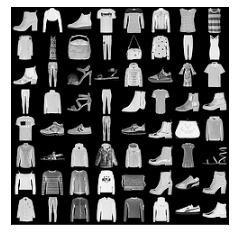

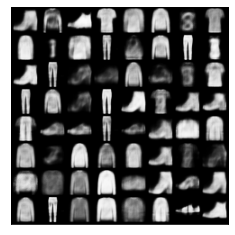

In [ ]:
show_batch(sf_batch)
show_batch(rec_x)

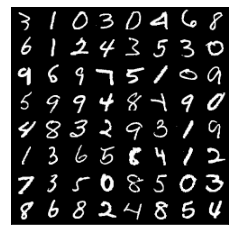

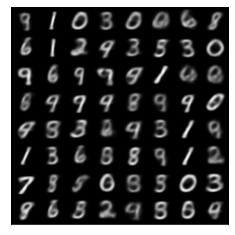

In [ ]:
rec_x, mu, logvar, x_halu, rec_x_halo, z_halu_old, z_halu, s_halu, atyp = cult_trainer.model(mnist_batch)
show_batch(mnist_batch)
show_batch(rec_x)

In [ ]:
cult_trainer.train_latent_classifiers([sf_loader, mnist_loader], [fashion_test_loader, mnist_test_loader], ["fashion_mnist", "mnist"], [10, 10], epochs=3, lr=1e-2)

  0%|          | 0/22 [00:00<?, ?it/s]

epoch 0 acc tensor(0.7713)
epoch 1 acc tensor(0.7830)
epoch 2 acc tensor(0.7707)
epoch 0 acc tensor(0.7430)
epoch 1 acc tensor(0.7759)
epoch 2 acc tensor(0.7879)


  5%|▍         | 1/22 [00:35<12:34, 35.95s/it]

epoch 0 acc tensor(0.7607)
epoch 1 acc tensor(0.7700)
epoch 2 acc tensor(0.7722)
epoch 0 acc tensor(0.6874)
epoch 1 acc tensor(0.7404)
epoch 2 acc tensor(0.7615)


  9%|▉         | 2/22 [01:11<11:57, 35.89s/it]

epoch 0 acc tensor(0.7530)
epoch 1 acc tensor(0.7493)
epoch 2 acc tensor(0.7584)
epoch 0 acc tensor(0.7166)
epoch 1 acc tensor(0.7511)
epoch 2 acc tensor(0.7714)


 14%|█▎        | 3/22 [01:46<11:15, 35.55s/it]

epoch 0 acc tensor(0.7529)
epoch 1 acc tensor(0.7647)
epoch 2 acc tensor(0.7767)
epoch 0 acc tensor(0.6806)
epoch 1 acc tensor(0.7436)
epoch 2 acc tensor(0.7515)


 18%|█▊        | 4/22 [02:21<10:32, 35.15s/it]

epoch 0 acc tensor(0.7564)
epoch 1 acc tensor(0.7536)
epoch 2 acc tensor(0.7625)
epoch 0 acc tensor(0.6674)
epoch 1 acc tensor(0.7147)
epoch 2 acc tensor(0.7323)


 23%|██▎       | 5/22 [02:56<09:58, 35.23s/it]

epoch 0 acc tensor(0.7564)
epoch 1 acc tensor(0.7725)
epoch 2 acc tensor(0.7696)
epoch 0 acc tensor(0.6897)
epoch 1 acc tensor(0.7300)
epoch 2 acc tensor(0.7602)


 27%|██▋       | 6/22 [03:30<09:15, 34.72s/it]

epoch 0 acc tensor(0.7583)
epoch 1 acc tensor(0.7665)
epoch 2 acc tensor(0.7718)
epoch 0 acc tensor(0.6366)
epoch 1 acc tensor(0.7013)
epoch 2 acc tensor(0.7334)


 32%|███▏      | 7/22 [04:06<08:44, 34.97s/it]

epoch 0 acc tensor(0.7523)
epoch 1 acc tensor(0.7576)
epoch 2 acc tensor(0.7671)
epoch 0 acc tensor(0.6568)
epoch 1 acc tensor(0.7074)
epoch 2 acc tensor(0.7245)


 36%|███▋      | 8/22 [04:43<08:20, 35.78s/it]

epoch 0 acc tensor(0.7465)
epoch 1 acc tensor(0.7696)
epoch 2 acc tensor(0.7758)
epoch 0 acc tensor(0.6431)
epoch 1 acc tensor(0.6959)
epoch 2 acc tensor(0.7267)


 41%|████      | 9/22 [05:16<07:34, 34.96s/it]

epoch 0 acc tensor(0.7557)
epoch 1 acc tensor(0.7741)
epoch 2 acc tensor(0.7690)
epoch 0 acc tensor(0.6316)
epoch 1 acc tensor(0.6917)
epoch 2 acc tensor(0.7113)


 45%|████▌     | 10/22 [05:45<06:36, 33.02s/it]

epoch 0 acc tensor(0.7541)
epoch 1 acc tensor(0.7691)
epoch 2 acc tensor(0.7683)
epoch 0 acc tensor(0.6388)
epoch 1 acc tensor(0.7124)
epoch 2 acc tensor(0.7408)


 50%|█████     | 11/22 [06:11<05:41, 31.01s/it]

epoch 0 acc tensor(0.7508)
epoch 1 acc tensor(0.7695)
epoch 2 acc tensor(0.7582)
epoch 0 acc tensor(0.8113)
epoch 1 acc tensor(0.8120)
epoch 2 acc tensor(0.8288)


 55%|█████▍    | 12/22 [06:39<04:59, 30.00s/it]

epoch 0 acc tensor(0.7518)
epoch 1 acc tensor(0.7590)
epoch 2 acc tensor(0.7697)
epoch 0 acc tensor(0.8467)
epoch 1 acc tensor(0.8563)
epoch 2 acc tensor(0.8621)


 59%|█████▉    | 13/22 [07:07<04:24, 29.40s/it]

epoch 0 acc tensor(0.7561)
epoch 1 acc tensor(0.7611)
epoch 2 acc tensor(0.7692)
epoch 0 acc tensor(0.8588)
epoch 1 acc tensor(0.8692)
epoch 2 acc tensor(0.8761)


 64%|██████▎   | 14/22 [07:34<03:49, 28.73s/it]

epoch 0 acc tensor(0.7488)
epoch 1 acc tensor(0.7690)
epoch 2 acc tensor(0.7650)
epoch 0 acc tensor(0.8485)
epoch 1 acc tensor(0.8632)
epoch 2 acc tensor(0.8729)


 68%|██████▊   | 15/22 [08:02<03:20, 28.58s/it]

epoch 0 acc tensor(0.7542)
epoch 1 acc tensor(0.7591)
epoch 2 acc tensor(0.7532)
epoch 0 acc tensor(0.8485)
epoch 1 acc tensor(0.8581)
epoch 2 acc tensor(0.8668)


 73%|███████▎  | 16/22 [08:33<02:54, 29.05s/it]

epoch 0 acc tensor(0.7508)
epoch 1 acc tensor(0.7612)
epoch 2 acc tensor(0.7649)
epoch 0 acc tensor(0.8473)
epoch 1 acc tensor(0.8592)
epoch 2 acc tensor(0.8648)


 77%|███████▋  | 17/22 [08:59<02:21, 28.35s/it]

epoch 0 acc tensor(0.7399)
epoch 1 acc tensor(0.7629)
epoch 2 acc tensor(0.7706)
epoch 0 acc tensor(0.8464)
epoch 1 acc tensor(0.8593)
epoch 2 acc tensor(0.8635)


 82%|████████▏ | 18/22 [09:25<01:50, 27.53s/it]

epoch 0 acc tensor(0.7545)
epoch 1 acc tensor(0.7649)
epoch 2 acc tensor(0.7635)
epoch 0 acc tensor(0.8548)
epoch 1 acc tensor(0.8608)
epoch 2 acc tensor(0.8653)


 86%|████████▋ | 19/22 [09:51<01:21, 27.09s/it]

epoch 0 acc tensor(0.7341)
epoch 1 acc tensor(0.7544)
epoch 2 acc tensor(0.7611)
epoch 0 acc tensor(0.8569)
epoch 1 acc tensor(0.8676)
epoch 2 acc tensor(0.8681)


 91%|█████████ | 20/22 [10:17<00:53, 26.89s/it]

epoch 0 acc tensor(0.7437)
epoch 1 acc tensor(0.7551)
epoch 2 acc tensor(0.7586)
epoch 0 acc tensor(0.8591)
epoch 1 acc tensor(0.8676)
epoch 2 acc tensor(0.8666)


 95%|█████████▌| 21/22 [10:43<00:26, 26.61s/it]

epoch 0 acc tensor(0.7483)
epoch 1 acc tensor(0.7563)
epoch 2 acc tensor(0.7681)
epoch 0 acc tensor(0.8510)
epoch 1 acc tensor(0.8638)
epoch 2 acc tensor(0.8660)


100%|██████████| 22/22 [11:09<00:00, 30.45s/it]
